# Store Sales - Time Series Forecasting
---

Using machine learning to predict grocery sales

In this notebook we will be solving the problem from the competiton: [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting) from [Kaggle](https://www.kaggle.com/)

### Summary:
*   In this competition, you’ll use time-series forecasting to forecast store sales on data from **Corporación Favorita**, a large Ecuadorian-based grocery retailer.
    *   Specifically, you'll build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores.  
    You'll practice your machine learning skills with an approachable training dataset of dates, store, and item information, promotions, and unit sales.

* The evaluation metric for this competition is Root Mean Squared Logarithmic Error - RMSLE.

### File Descriptions and Data Field Information

#### `train.csv`
The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

*   **store_nbr** identifies the store at which the products are sold.
*   **family** identifies the type of product sold.
*   **sales** gives the total sales for a product family at a particular store at a given date.  
    Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
*   **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.

#### `test.csv`
The test data, having the same features as the training data.  
You will predict the target sales for the dates in this file.  
*   The dates in the test data are for the 15 days after the last date in the training data.

#### `sample_submission.csv`
*   A sample submission file in the correct format.

#### `stores.csv`
Store metadata, including city, state, type, and cluster.
*   **cluster** is a grouping of similar stores.

#### `oil.csv`
Daily oil price.  
Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

#### `holidays_events.csv`
Holidays and Events, with metadata  


### NOTES:
Pay special attention to the transferred column.  
*   A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government.

*   A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is **Transfer**.  
    *   For example, the holiday ***Independencia de Guayaquil*** was transferred from **2012-10-09** to **2012-10-12**, which means it was celebrated on **2012-10-12**.  

*   Days that are type **Bridge** are extra days that are added to a holiday (e.g., to extend the break across a long weekend).  

*   These are frequently made up by the type **Work Day** which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the **Bridge**.

*   Additional holidays are days added a regular calendar holiday, for example, as typically happens around **Christmas** (making Christmas Eve a holiday).

*   Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. **Supermarket sales could be affected by this.**

*   A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

Extracting file from the `.zip`

In [ ]:
import zipfile
from pathlib import Path

Path("data").mkdir(parents=True, exist_ok=True)

file_path = Path("data/train.csv")
if not file_path.is_file():
    with zipfile.ZipFile("./store-sales-time-series-forecasting.zip", 'r') as zf:
        zf.extractall("./data/")

Reading the `train.csv` file:

In [ ]:
import pandas as pd
import numpy as np
train_path = "./data/train.csv"

sales = pd.read_csv(
    train_path,
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date']
    )

sales = sales.set_index('date').to_period('D')
sales = sales.set_index(['store_nbr', 'family'], append=True)
average_sales = sales.groupby('date').mean()['sales']

Let's check how the dataset is composed:

In [ ]:
sales.info()

In [ ]:
sales.describe()

In [ ]:
stores = pd.read_csv("./data/stores.csv")

stores.head()

Defining some parameters for the plots:

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

Plotting a graph for the average sales:

In [ ]:
import matplotlib.pyplot as plt

trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

plt.figure(figsize=(12, 6))
ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)
ax.set_title("Average Sales (2013 - 2017)")

## Training our first model for TimeSeries
---

For training the model:
*   First let's unstack our index, making every index from the MultiIndex became a feature;
*   For this model we will use DeterministicProcess from statsmodels
*   We will be also using CalendarFourier from statsmodels tsa (Time Series Analysis) module.

In [ ]:
y_targets = sales.unstack(['store_nbr', 'family'])

For the first model, let's start using only 1 year -> **2017**

In [ ]:
y_targets = y_targets.loc['2017']

Now let's create our training data:

In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(
    freq='M',
    order=4
)

dp = DeterministicProcess(
    index=y_targets.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)

X = dp.in_sample()

In [ ]:
X.head()

In [ ]:
X['NewYear'] = (X.index.dayofyear == 1)

X.head()

Let's train the model:

In [ ]:
from sklearn.linear_model import LinearRegression


model = LinearRegression(fit_intercept=False)
model.fit(X, y_targets)

y_predicted = pd.DataFrame(
    data=model.predict(X),
    index=X.index,
    columns=y_targets.columns
)

y_predicted.head()

Now let's see how or models work for a specified family:
*   In this case we will use `family = 'AUTOMOTIVE'`

In [ ]:
FAMILY = 'AUTOMOTIVE'
STORE = '1'

X_forecasted = dp.out_of_sample(30)
X_forecasted["NewYear"] = (X_forecasted.index.dayofyear == 1)

y_forecasted = pd.DataFrame(
    data=model.predict(X_forecasted),
    index=X_forecasted.index,
    columns=y_targets.columns
)

ax = y_targets.loc(axis=1)['sales', STORE, FAMILY].plot(**plot_params, label='Sales')
ax = y_predicted.loc(axis=1)['sales', STORE, FAMILY].plot(ax=ax, label='Predicted')
ax = y_forecasted.loc(axis=1)['sales', STORE, FAMILY].plot(ax=ax, label='Forecasted')
ax.set_title(f'{FAMILY} Sales at Store {STORE}')
ax.legend()

plt.show()

Creating the first submission to Kaggle:

In [ ]:
df_test = pd.read_csv(
    './data/test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['date', 'store_nbr', 'family',]).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=df_test.index.get_level_values('date').unique().shape[0])
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)


y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y_targets.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test['id']).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

## Using time series as features
---
Some time series properties can only be modeled as serially dependent properties, that is, using as features past values of the target series.

### Lagged Series and Lag Plots
To investigate possible serial dependence (like cycles) in a time series, we need to create "lagged" copies of the series. Lagging a time series means to shift its values forward one or more time steps, or equivalently, to shift the times in its index backward one or more steps. In either case, the effect is that the observations in the lagged series will appear to have happened later in time.

This shows the monthly unemployment rate in the US (`y`) together with its first and second lagged series (`y_lag_1` and `y_lag_2`, respectively). Notice how the values of the lagged series are shifted forward in time.

In [ ]:
# First, let's check if `average sales` has cyclic behavior:

average_sales_2017 = average_sales.loc['2017']

fourier = CalendarFourier(
    freq='M',
    order=4
)
dp = DeterministicProcess(
    index=average_sales_2017.index,
    constant=True,
    order=1,
    seasonal=True,
    drop=False,
    additional_terms=[fourier]
)

X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X, average_sales_2017)

average_deseason = average_sales_2017 - model.predict(X)
average_deseason.name = 'average_sales_deseasoned'

# Moving average
moving_avg = average_deseason.rolling(
    window=7,
    center=True
).mean()

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

fig.set_size_inches(12, 6)

average_deseason.plot(ax=ax1, title='Average Sales 2017 Deseasoned')
moving_avg.plot(ax=ax2, title='Moving Average')

plt.show()

Looking at the average sales deseasoned and her moving average, we can't see clearly a cyclic behavior.

Let's check for a specific Product Family: **SCHOOL AND OFFICE SUPPLIES** and see how it goes

In [ ]:
sales = pd.read_csv(
    train_path,
    usecols=['family', 'date', 'sales', 'onpromotion'],
    dtype={
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date']
    )

family_sales = (
    sales
    .groupby(['family', 'date'], observed=True)
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

In [ ]:

ofc_sup_sales_2017 = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']

y = ofc_sup_sales_2017.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(
    freq='M',
    order=4
)
dp = DeterministicProcess(
    index=average_sales_2017.index,
    constant=True,
    order=1,
    seasonal=True,
    drop=False,
    additional_terms=[fourier]
)

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.set_size_inches(12, 6)

y_deseason.plot(ax=ax1)
ax1.set_title("Sales of School and Office Supplies (deseasonalized)")

y_ma = y.rolling(
    window=7,
    center=True
).mean()

y_ma.plot(ax=ax2)
ax2.set_title("Seven-Day Moving Average")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from utils import make_lags, make_leads

onpromotion = ofc_sup_sales_2017.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

X_lags = make_lags(y_deseason, lags=1)

X_promo = pd.concat([
    make_lags(onpromotion, lags=1),
    onpromotion,
    make_leads(onpromotion, leads=1)
], axis=1)

X = pd.concat([X_lags, X_promo], axis=1)
y, X = y.align(X, join='inner')

X = X.fillna(0.0)


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit)**0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred)**0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

plt.figure(figsize=(12, 6))
ax = y.plot(**plot_params, alpha=0.5, title="Onpromotion Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend()

plt.show()

## Second approach: Using all data to build a hybrid model
---
In this second attempt to decrease RMSLE, we will be using all of the Data that were provided for the competition:
*   `train.csv`
*   `stores.csv`
*   `oil.csv`
*   `holidays_events.csv`

In [ ]:
# Importing all libraries we are going to use:
import sys
import pathlib
libpath = str(pathlib.Path().resolve().parent)
sys.path.append(libpath)
import utils
import pandas as pd
import numpy as np

In [ ]:
# Assign all files to a variable:
sales = pd.read_csv('./data/train.csv', dtype={'date':'str'}, parse_dates=['date'])
stores = pd.read_csv('./data/stores.csv')
oil = pd.read_csv('./data/oil.csv', dtype={'date':'str'}, parse_dates=['date']).rename(columns={'dcoilwtico':'oil_price'})
holidays = pd.read_csv('./data/holidays_events.csv', dtype={'date':'str'}, parse_dates=['date'])

train = sales.copy()
test = pd.read_csv('./data/test.csv', dtype={'date':'str'}, parse_dates=['date'])

Merging the datasets:

In [ ]:
# oil -> train, test
train = pd.merge(train, oil, on='date', how='left')
test = pd.merge(test, oil, on='date', how='left')

# stores -> train, test
train = pd.merge(train, stores, on='store_nbr', how='left')
test = pd.merge(test, stores, on='store_nbr', how='left')

# Making holidays useful
useless_days = (holidays['transferred'] == True) | (holidays['type'] == 'Work Day')
tHolidays = holidays.drop(holidays[useless_days].index)
tHolidays = tHolidays.drop(['type', 'description', 'transferred'], axis=1)
tHolidays['holiday'] = 1
tHolidays = tHolidays.drop(tHolidays[tHolidays['date'].duplicated()].index)

# Splitting holidays by 'locale' -> Local, Regional, National
local_holidays = tHolidays[tHolidays['locale'] == 'Local']
regional_holidays = tHolidays[tHolidays['locale'] == 'Regional']
national_holidays = tHolidays[tHolidays['locale'] == 'National'].drop(['locale', 'locale_name'], axis=1) 

# national_holidays -> train, test
train = pd.merge(train, national_holidays, on='date', how='left')
test = pd.merge(test, national_holidays, on='date', how='left')

# regional_holidays -> train, test
for date, state in zip(regional_holidays['date'], regional_holidays['locale_name']):
    train.loc[(train['date'] == date) & (train['state'] == state), 'holiday'] = 1

for date, state in zip(regional_holidays['date'], regional_holidays['locale_name']):
    test.loc[(test['date'] == date) & (test['state'] == state), 'holiday'] = 1

# local_holidays -> train, test
for date, city in zip(local_holidays['date'], local_holidays['locale_name']):
    train.loc[(train['date'] == date) & (train['city'] == city), 'holiday'] = 1

for date, city in zip(local_holidays['date'], local_holidays['locale_name']):
    test.loc[(test['date'] == date) & (test['city'] == city), 'holiday'] = 1

In [ ]:
print("Null values in the train set:")
display(train.isnull().sum())

print("Null values in the test set:")
display(test.isnull().sum())

*   Using the Dataframe.bfill and Dataframe.ffill methods:

    *   `Dataframe.bfill()` method is used to backward fill the missing values in the dataset.  
    It will backward fill the `NaN` values that are present in the pandas dataframe.

    *   `Dataframe.ffill()` method is used to forward fill the missing values in the dataset.  
    It will forward fill the `NaN` values that are present in the pandas dataframe.

In [ ]:
# Train -> bfill() and ffill()
train.loc[:, 'oil_price'] = train['oil_price'].bfill().ffill()

# Test -> bfill() and ffill()
test.loc[:, 'oil_price'] = test['oil_price'].bfill().ffill()

In [ ]:
print("Null values in the train set:")
display(train.isnull().sum())

print("Null values in the test set:")
display(test.isnull().sum())

*   For holidays, if the value is `NaN`, we will fill it with `0`, just to avoid problems on our models.

In [ ]:
# Train -> fillna()
train.loc[:, 'holiday'] = train['holiday'].fillna(value=0)

# Test -> fillna()
test.loc[:, 'holiday'] = test['holiday'].fillna(value=0)

In [ ]:
print("Null values in the train set:")
display(train.isnull().sum())

print("Null values in the test set:")
display(test.isnull().sum())

*   The column called `"id"` has the same values of our index, so we can either remove this feature or set it as our new index.

In [ ]:
# Train -> set the 'id' feature as index
train.set_index('id', inplace=True)

# test -> set the 'id' feature as index
test.set_index('id', inplace=True)

### Lag Features

Lag features are very commom in Time Series problems

*   In this project we will be using 3 lag features:
   *   7 days;
   *   14 days;
   *   28 days;


In [ ]:
def lag_sales(df, date_column, sales_column, lag_days=1):
    df_copy = df.copy()
    df_copy[date_column] += pd.Timedelta(days=lag_days)
    df_copy.rename(columns={sales_column : f'sales_{lag_days}_days_ago'}, inplace=True)
    df_copy = pd.merge(left=df,
                       right=df_copy.loc[:, ['store_nbr', 'family', 'date', f'sales_{lag_days}_days_ago']],
                       on=['store_nbr', 'family', 'date'],
                       how='left')
    df_copy.loc[:, f'sales_{lag_days}_days_ago'].fillna(0, inplace=True)
    return df_copy

In [ ]:
temp_df = pd.concat([train, test])

# Train -> Adding lag features for 7, 14 and 28 days:
for days in [7, 14, 28]:
    train = lag_sales(train, 'date', 'sales', lag_days=days)


# creating lag features for the test set, using the last data from de train set
for days in [7, 14, 28]:
    temp_df = lag_sales(temp_df, 'date', 'sales', lag_days=days)

test = temp_df.loc[temp_df['date'] >= test['date'].min(), :]

## Feature Engineering:

*   Let's create some features that will help us explain some behaviors of our data
    *   For that we will be using a custom method called `add_datepart()` from a custom module I created called `utils`

In [ ]:
# Train -> Feature Engineering
train = utils.add_datepart(df=train, fldnames='date', drop=False)

# Test -> Feature Engineering
test = utils.add_datepart(df=test, fldnames='date', drop=False)

# This methods executes inplace, so theres no need to do "train/test = utils.add_datepart(...)"

### Average Sales Feature

Let's create a feature that computes the average sales, considering:
*   Store: For that we will use `store_nbr`
*   Family: The family of products -> `family`
*   Day of the week: From the feature `Dayofweek`

In [ ]:
grouped_df = train.groupby(['store_nbr', 'family', 'Dayofweek'])['sales'].mean().reset_index()
grouped_df.rename(columns={'sales' : 'avg_sales'}, inplace=True)
train = train.merge(right= grouped_df,
                    on=['store_nbr', 'family', 'Dayofweek'],
                    how='left')
test = test.merge(right= grouped_df,
                    on=['store_nbr', 'family', 'Dayofweek'],
                    how='left')

In [ ]:
train.info()

*   Now, we should remove useless columns that won't add useful information to our model, such as:
    *   `city`: We used the city and state feature to create our `'holiday'` feature, so we no longer need these feature.
    *   `state`: Same as above.
    *   `cluster`: This feature is about which store cluster the respective store belongs to, which is almost useless to our model.
    *   `store_nbr`: Similar to the above feature, it only tells us the identifier to a certain store, which is almost useless to our model.

In [ ]:
# Train -> drop useless features
#train = train.drop(['city', 'state', 'cluster', 'store_nbr'], axis=1)

# Test -> drop useless features
#test = test.drop(['city', 'state', 'cluster', 'store_nbr'], axis=1)

### Training our model:
---
We will use a validation set, consisting of:
*   The last 15 days of the training set.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define the column transformer
column_transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False), train.select_dtypes('object').columns.to_list())
    ],
    remainder='passthrough'  # Keeps the other columns (not 'object') as is
)

transformed_df_train = column_transformer.fit_transform(train.select_dtypes('object'))
transformed_df_test = column_transformer.transform(test.select_dtypes('object'))

new_column_names = column_transformer.get_feature_names_out().tolist()

# Convert the result back to a DataFrame
transformed_df_train = pd.DataFrame(transformed_df_train.astype(np.int64), columns=new_column_names)
transformed_df_test = pd.DataFrame(transformed_df_test.astype(np.int64), columns=new_column_names)

In [ ]:
train = pd.concat([train.drop(columns=train.select_dtypes('object').columns.tolist()), transformed_df_train], axis=1)
test = pd.concat([test.drop(columns=test.select_dtypes('object').columns.tolist()).reset_index(drop=True), transformed_df_test], axis=1)

In [ ]:
display(train.head())
display(test.head())

In [ ]:
val_set = train.loc[train['date'] >= '2017-08-01', :].copy()
train = train.loc[train['date'] < '2017-08-01', :]

In [ ]:
val_set

In [ ]:
X_train = train.drop(['date', 'sales'], axis=1)
y_train = train.loc[:, 'sales']

X_val = val_set.drop(['date', 'sales'], axis=1)
y_val = val_set.loc[:, 'sales']

X_test = test.drop(['date', 'sales'], axis=1)

### DATA LEAKAGE ALERT:

*   As we decided to use a validation set, we need to consider it as something that wasn't seen before, this implies that:
    *   In our test set, the lag features for 7 and 14 days should be `NaN`, since those days belongs to the validation set!

In [ ]:
test.loc[:, ['sales_7_days_ago', 'sales_14_days_ago',]] = np.nan

### HistGradientBoostingRegressor:

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgbr = HistGradientBoostingRegressor(random_state=100)

hgbr.fit(X_train, y_train)

In [ ]:
y_val_pred = hgbr.predict(X_val)

### Evaluating our model:

In [ ]:
from sklearn.metrics import mean_squared_log_error

msle = mean_squared_log_error(y_val, y_val_pred)
rmsle = np.sqrt(msle)

print(f'Root Mean Squared Log Error: {rmsle}')

### Creating the Second Submission to the Competition:

In [ ]:
df_test = pd.read_csv(
    './data/test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
)

y_submit = pd.DataFrame(hgbr.predict(X_test), index=df_test.id, columns=['sales']).reset_index()
y_submit.to_csv('submission.csv', index=False)

## Third Approach:
---

### Fourier Features:
*   Let's add Fourier Features and select the best `order` hiperparameter using cross validation

In [ ]:
# Importing all libraries we are going to use:
import sys
import pathlib
libpath = str(pathlib.Path().resolve().parent)
sys.path.append(libpath)
import utils
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [ ]:
# Assign all files to a variable:
sales = pd.read_csv('./data/train.csv', dtype={'date':'str'}, parse_dates=['date'])
sales['date'] = pd.to_datetime(sales['date'])

stores = pd.read_csv('./data/stores.csv')
oil = pd.read_csv('./data/oil.csv', dtype={'date':'str'}, parse_dates=['date']).rename(columns={'dcoilwtico':'oil_price'})
holidays = pd.read_csv('./data/holidays_events.csv', dtype={'date':'str'}, parse_dates=['date'])

train = sales.copy()
test = pd.read_csv('./data/test.csv', dtype={'date':'str'}, parse_dates=['date'])

#### Visualizing Data with Plotly
---
Instead of using the normal matplotlib, we will use Plotly Express, because it gives us interactivity

In [ ]:
import plotly.express as px

sales = sales.set_index('date')
sales_fam = sales.loc[(sales['family'] == 'AUTOMOTIVE') & (sales['store_nbr'] == 2), 'sales']

fig = px.line(sales_fam, title="Sales from 2013 to 2017")
fig.show()

Doing cross validation to choose the best `order` hiperparameter for CalendarFourier  
Uncomment the following cell if you want to see the process, but for our case, `order=3` was the best!

In [ ]:
'''
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

def create_fourier_features(df, order, frequency:str):
    fourier = CalendarFourier(freq=frequency, order=order)
    dp = DeterministicProcess(
        index=df.index,
        constant=True,                # Add a constant term for the intercept
        order=1,                      # Linear trend
        seasonal=False,               # No seasonal terms
        additional_terms=[fourier],   # Add Fourier terms
        drop=True                     # Drop missing dates
    )
    return dp.in_sample()


def cross_val_score_for_order(df, y, order):
    tscv = TimeSeriesSplit(n_splits=5)
    mse_scores = []
    
    for train_index, test_index in tscv.split(df):
        df_train, df_test = df.iloc[train_index], df.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Create Fourier features
        X_train = create_fourier_features(df_train, order, 'M')
        X_test = create_fourier_features(df_test, order, 'M')
        
        # Fit a model (e.g., linear regression)
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Predict and calculate MSE
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)
        
    return np.mean(mse_scores)



# Evaluate performance for different orders
orders = range(1, 21)  # Define a range of orders to test
results = {}

for order in orders:
    mse = cross_val_score_for_order(sales.drop('sales', axis=1), sales['sales'], order)
    results[order] = mse
    print(f'Order: {order}, MSE: {mse}')

# Find the best order with the lowest MSE
best_order = min(results, key=results.get)
print(f'Best order: {best_order}, with MSE: {results[best_order]}')
'''

In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

fourier = CalendarFourier(freq='M', order=3)
dp = DeterministicProcess(
    index=sales.index,
    constant=True,                # Add a constant term for the intercept
    order=0,                      # No trend added
    seasonal=False,               # No seasonal terms
    additional_terms=[fourier],   # Add Fourier terms
    drop=True                     # Drop missing dates
)

sales = pd.concat([sales, dp.in_sample()], axis=1)

In [ ]:
test = test.set_index('date')
test = pd.concat([test, dp.out_of_sample(test.index.shape[0], test.index)], axis=1)

In [ ]:
def create_train_test_lag(train, test, target, lag_days):
    assert train.shape[1] >= test.shape[1]
    df = pd.concat([train, test], axis=0)
    return utils.make_lags(df.loc[:, target], lag_days)

In [ ]:
lagged_features = create_train_test_lag(sales, test, 'sales', [7, 14, 28])
sales_lagged_features = lagged_features.loc[lagged_features.index < test.index[0]]
test_lagged_features = lagged_features.loc[lagged_features.index >= test.index[0]]

In [ ]:
sales = pd.concat([sales, sales_lagged_features], axis=1)
test = pd.concat([test, test_lagged_features], axis=1)

In [ ]:
sales = sales.fillna(0)
test = test.fillna(0)

In [ ]:
train = sales.loc[sales.index<='2017-07-30']
train = pd.concat([train.drop('family', axis=1), pd.get_dummies(train['family'])], axis=1)

validation = sales.loc[sales.index>'2017-07-30']
validation = pd.concat([validation.drop('family', axis=1), pd.get_dummies(validation['family'])], axis=1)

test = pd.concat([test.drop('family', axis=1), pd.get_dummies(test['family'])], axis=1)

In [ ]:
X_train = train.drop(['sales', 'id'], axis=1)
y_train = train['sales']

X_validation = validation.drop(['sales', 'id'], axis=1)
y_validation = validation['sales']

In [ ]:
X_train

In [ ]:
lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(X_train, y_train)

In [ ]:
y_predicted = pd.Series(lin_reg.predict(X_validation).clip(0.0), index=y_validation.index, name='predicted')

In [ ]:
from sklearn.metrics import mean_squared_log_error

mean_squared_log_error(y_validation, y_predicted)**0.5

In [ ]:
pd.DataFrame(pd.concat([y_validation, y_predicted], axis=1))

In [ ]:
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': lin_reg.coef_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
feature_importance

In [ ]:
predictions = lin_reg.predict(test.drop('id', axis=1)).clip(0.0)

In [ ]:
submission = pd.DataFrame(data={'id':test.id, 'sales':predictions}).reset_index(drop=True)
submission.to_csv('submission.csv', index=False)

## Fourth Approach: Hybrid Model
---

In [53]:
import sys
import pathlib
libpath = str(pathlib.Path().resolve().parent)
sys.path.append(libpath)
import utils
import pandas as pd
import numpy as np

In [100]:
# Assign all files to a variable:
sales = pd.read_csv('./data/train.csv', dtype={'date':'str', 'family':'category', 'store_nbr':'category'}, parse_dates=['date'])
sales['date'] = pd.to_datetime(sales['date'])

stores = pd.read_csv('./data/stores.csv')
oil = pd.read_csv('./data/oil.csv', dtype={'date':'str'}, parse_dates=['date']).rename(columns={'dcoilwtico':'oil_price'})
holidays = pd.read_csv('./data/holidays_events.csv', dtype={'date':'str'}, parse_dates=['date'])

train = sales.copy()
test = pd.read_csv('./data/test.csv', dtype={'date':'str'}, parse_dates=['date'])

In [101]:
sales['date'] = sales['date'].dt.to_period('D')
sales = sales.loc[sales.family == 'AUTOMOTIVE', :]
sales = sales.loc[sales['store_nbr'] == '1', :]
sales = sales.loc[sales['date'] >= '2017', :]

In [102]:
sales = sales.drop('id', axis=1).set_index(['store_nbr', 'family', 'date'])
y = sales.drop('onpromotion', axis=1)
sales

sales  onpromotion
store_nbr family     date                          
1         AUTOMOTIVE 2017-01-01    0.0            0
                     2017-01-02    5.0            0
                     2017-01-03    4.0            0
                     2017-01-04    1.0            0
                     2017-01-05    2.0            0
...                                ...          ...
                     2017-08-11    1.0            0
                     2017-08-12    6.0            0
                     2017-08-13    1.0            0
                     2017-08-14    1.0            0
                     2017-08-15    4.0            0

[227 rows x 2 columns]

In [103]:
y = y.unstack(['family'])
y = y.reset_index('store_nbr', drop=True)
y.head()

,sales
family,AUTOMOTIVE
date,
2017-01-01,0.0
2017-01-02,5.0
2017-01-03,4.0
2017-01-04,1.0
2017-01-05,2.0


In [71]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=2,
    drop=True
)

In [72]:
X = dp.in_sample()
X.head()

,const,trend,trend_squared
date,,,
2017-01-01,1.0,1.0,1.0
2017-01-02,1.0,2.0,4.0
2017-01-03,1.0,3.0,9.0
2017-01-04,1.0,4.0,16.0
2017-01-05,1.0,5.0,25.0


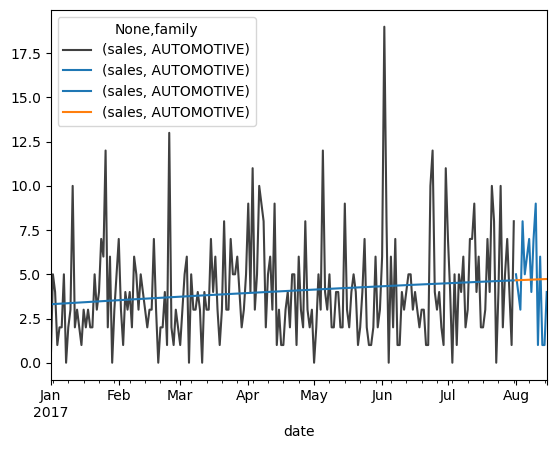

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Splitting data for validation
idx_train, idx_test = train_test_split(X.index, test_size=15, shuffle=False)

X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train, :], y.loc[idx_test, :]

# Training the model to capture trend
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', sharex=True)
axs = y_fit.plot(color='C0', sharex=True, ax=axs)
axs = y_test.plot(sharex=True, ax=axs)
axs = y_pred.plot(sharex=True, ax=axs)

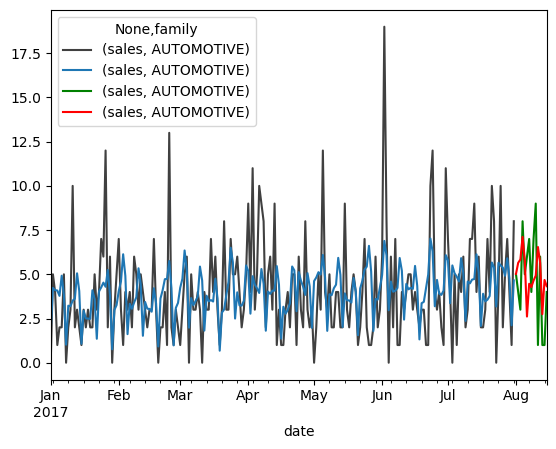

In [84]:
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

fourier = CalendarFourier(
    freq='M',
    order=4
)

dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    drop=True,
    seasonal=True,
    additional_terms=[fourier]
)

X = dp.in_sample()

# Splitting data for validation
idx_train, idx_test = train_test_split(X.index, test_size=15, shuffle=False)

X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train, :], y.loc[idx_test, :]

# Training the model to capture trend
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', sharex=True)
axs = y_fit.plot(color='C0', sharex=True, ax=axs)
axs = y_test.plot(color='g',sharex=True, ax=axs)
axs = y_pred.plot(color='r',sharex=True, ax=axs)

In [93]:
from sklearn.metrics import mean_squared_log_error

mean_squared_log_error(y_train, y_fit)**0.5

0.5299473451081071

In [133]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_log_error
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

def rmsle(y_true, y_pred):
    return mean_squared_log_error(y_true, y_pred)**0.5

def create_deterministic_process_model(df, freq, order):
    # Create Fourier terms
    fourier = CalendarFourier(freq=freq, order=order)
    
    # Define Deterministic Process
    dp = DeterministicProcess(
        index=df.index,
        order=1,  # This is for the linear trend
        additional_terms=[fourier],
        drop=True
    )
    
    X = dp.in_sample()
    return X

class CustomGridSearch:
    def __init__(self, model, param_grid, scoring) -> None:
        self.model = model
        self.param_grid = param_grid
        self.scoring = scoring
        self.best_params_ = None
        self.best_score_ = None
    
    def fit(self, y):
        best_score = float('inf')
        best_params = None
        
        for freq in self.param_grid['freq']:
            for order in self.param_grid['order']:
                model = LinearRegression(fit_intercept=False)
                X_transformed = create_deterministic_process_model(y, freq, order)
                scores = []
                
                train_index, test_index = train_test_split(X_transformed.index, test_size=15, shuffle=False)
                X_train, X_test = X_transformed.loc[train_index], X_transformed.loc[test_index]
                y_train, y_test = y.loc[train_index], y.loc[test_index]
                
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test).clip(0.0)
                score = rmsle(y_true=y_test, y_pred=y_pred)
                scores.append(score)
                
                avg_score = np.mean(scores)
                if avg_score < best_score:
                    best_score = avg_score
                    best_params = {'freq': freq, 'order': order}
        
        self.best_params_ = best_params
        self.best_score_ = best_score

np.random.seed(42)
scorer = make_scorer(rmsle, greater_is_better=False)

In [134]:
param_grid = {
    'freq': ['W', 'M', 'A'],  # Weekly, monthly, annualy seasonality
    'order': [1, 2, 3, 4, 5, 6, 7]          # Different orders of Fourier terms
}

grid_search = CustomGridSearch(model=LinearRegression(),
                               param_grid=param_grid,
                               scoring=scorer)

grid_search.fit(y)

In [138]:
pd.read_csv('./data/train.csv', dtype={'date':'str', 'family':'category', 'store_nbr':'category'}, parse_dates=['date'])['family'].unique()

['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', ..., 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']
Length: 33
Categories (33, object): ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', ..., 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']

In [141]:
family_store_grid = {
    'family' : ['AUTOMOTIVE', 'BABY CARE', 'BEVERAGES'],
    'store_nbr' : ['1', '2', '3']
}
param_grid = {
    'freq': ['W', 'M', 'A'],  # Weekly, monthly, annualy seasonality
    'order': [1, 2, 3, 4, 5]          # Different orders of Fourier terms
}


for store in family_store_grid['store_nbr']:
    for family in family_store_grid['family']:
        sales = pd.read_csv('./data/train.csv', dtype={'date':'str', 'family':'category', 'store_nbr':'category'}, parse_dates=['date'])
        sales['date'] = pd.to_datetime(sales['date'])

        sales['date'] = sales['date'].dt.to_period('D')
        sales = sales.loc[sales.family == family, :]
        sales = sales.loc[sales['store_nbr'] == store, :]
        sales = sales.loc[sales['date'] >= '2017', :]

        sales = sales.drop('id', axis=1).set_index(['store_nbr', 'family', 'date'])
        y = sales.drop('onpromotion', axis=1)
        y = y.unstack(['family'])
        y = y.reset_index('store_nbr', drop=True)

        grid_search = CustomGridSearch(model=LinearRegression(),
                                    param_grid=param_grid,
                                    scoring=scorer)

        grid_search.fit(y)

        print("STORE_NBR: ", store, "   FAMILY: ", family)
        print("Best parameters: ", grid_search.best_params_)
        print("With RSMLE score = ", grid_search.best_score_)
        print("\n\n")

STORE_NBR:  1    FAMILY:  AUTOMOTIVE
Best parameters:  {'freq': 'A', 'order': 3}
With RSMLE score =  0.4886685489427717



STORE_NBR:  1    FAMILY:  BABY CARE
Best parameters:  {'freq': 'W', 'order': 1}
With RSMLE score =  0.0



STORE_NBR:  1    FAMILY:  BEVERAGES
Best parameters:  {'freq': 'A', 'order': 3}
With RSMLE score =  0.35833243070742254



STORE_NBR:  2    FAMILY:  AUTOMOTIVE
Best parameters:  {'freq': 'A', 'order': 1}
With RSMLE score =  0.8015330678892927



STORE_NBR:  2    FAMILY:  BABY CARE
Best parameters:  {'freq': 'A', 'order': 2}
With RSMLE score =  0.0



STORE_NBR:  2    FAMILY:  BEVERAGES
Best parameters:  {'freq': 'A', 'order': 5}
With RSMLE score =  0.23481323683130242



STORE_NBR:  3    FAMILY:  AUTOMOTIVE
Best parameters:  {'freq': 'A', 'order': 3}
With RSMLE score =  0.4400425369033661



STORE_NBR:  3    FAMILY:  BABY CARE
Best parameters:  {'freq': 'A', 'order': 5}
With RSMLE score =  0.5253426219101123



STORE_NBR:  3    FAMILY:  BEVERAGES
Best paramete